In [2]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.pipeline import Pipeline
# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,ElasticNetCV,ElasticNet
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import lightgbm as lgb

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train = pd.read_pickle('../data/feature_engineering/sub_train_bin.pkl')
test = pd.read_pickle('../data/feature_engineering/sub_test_bin.pkl')

In [4]:
train_X = train.drop(['sample_name','phenotype_status'],axis=1).values
test_X = test.drop(['sample_name','phenotype_status'],axis=1).values
# train_X = train[kept_TCRs].values
# test_X = test[kept_TCRs].values
train_y = train['phenotype_status'].values
test_y = test['phenotype_status'].values

## Select 100 features

## Fisher exact test

In [5]:
def cal_p_value1(present_c0,present_c1,class_counts,alternative='greater'):
    '''
    present_c0: the number of negative samples where the TCR present
    present_c1: the number of positive samples where the TCR present
    class_counts: the class distribution: [class_negative(0),class_positive(1)]
    alternative: Choose the type of test: greater, less, two_sided

    contingency table: [[present_c1, absent_c1], [present_c0, absent_c0]]
    '''

    absent_c0 = class_counts[0]-present_c0 # the number of negative samples where the TCR absent 
    absent_c1 = class_counts[1]-present_c1 # the number of positive samples where the TCR absent

    # Conducting fisher exact test 
    _, pvalue = fisher_exact([[present_c1, absent_c1], [present_c0, absent_c0]],alternative=alternative)
    return pvalue

In [57]:
TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns.values

class_counts = train.phenotype_status.value_counts()
a = train[train.phenotype_status==0][TCRs].apply(np.count_nonzero,axis=0)
b = train[train.phenotype_status==1][TCRs].apply(np.count_nonzero,axis=0)
temp = pd.DataFrame({'status-':a,'status+':b})
temp['p_value']=temp.apply(lambda row: cal_p_value1(row['status-'], row['status+'],class_counts=class_counts), axis=1)

kept_TCRs = temp.nsmallest(100,'p_value').T.columns.values
ind = [train[TCRs].columns.get_loc(c) for c in kept_TCRs]


In [60]:
Fisher = ['True' if i in ind else 'False' for i in range(len(TCRs)) ]

## RFE

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(train_X, train_y)

Fitting estimator with 165 features.
Fitting estimator with 155 features.
Fitting estimator with 145 features.
Fitting estimator with 135 features.
Fitting estimator with 125 features.
Fitting estimator with 115 features.
Fitting estimator with 105 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=100, step=10, verbose=5)

In [11]:
rfe_support = rfe_selector.get_support()
rfe_feature = train[TCRs].loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


## Select from Model

### LR

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(), 'median')
embeded_lr_selector.fit(train_X, train_y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train[TCRs].loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

83 selected features


### Random Forest

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='0.8*median')
embeded_rf_selector.fit(train_X, train_y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = train[TCRs].loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

101 selected features


### LightGBM

In [42]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier()

embeded_lgb_selector = SelectFromModel(lgbc, threshold='median')
embeded_lgb_selector.fit(train_X, train_y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train[TCRs].loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

88 selected features


## Voting

In [66]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'TCR':TCRs, 'Fisher':Fisher, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','TCR'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

,Fisher,LightGBM,Logistics,RFE,Random Forest,TCR,Total
1,True,True,True,True,True,"(TCRBV29, TCRBV29-01, 01, CSVRDNFNQPQHF, TCRBJ...",4
2,True,True,True,True,True,"(TCRBV28, TCRBV28-01, 01, CASSPPSGLTDTQYF, TCR...",4
3,True,True,True,True,True,"(TCRBV28, TCRBV28-01, 01, CASSIEGNQPQHF, TCRBJ...",4
4,False,True,True,True,True,"(TCRBV28, TCRBV28-01, 01, CASRPQGNYGYTF, TCRBJ...",4
5,True,True,True,True,True,"(TCRBV27, TCRBV27-01, 01, CASMGGASYEQYF, TCRBJ...",4
6,True,True,True,True,True,"(TCRBV25, TCRBV25-01, 01, CASSPGDEQYF, TCRBJ02...",4
7,True,True,True,True,True,"(TCRBV25, TCRBV25-01, 01, CASSPGDEQFF, TCRBJ02...",4
8,True,True,True,True,True,"(TCRBV24, unresolved, null, CATSDSVTNTGELFF, T...",4
9,True,True,True,True,True,"(TCRBV24, unresolved, null, CATSDGETQYF, TCRBJ...",4
10,True,True,True,True,True,"(TCRBV24, unresolved, null, CATSDGDEQFF, TCRBJ...",4


## Test

In [76]:
kept_100 = feature_selection_df[:100]['TCR'].values
sub_train_X = train[kept_100]
sub_test_X = test[kept_100]

In [90]:
sub_train_X['sum'] = sub_train_X.apply(np.sum,axis=1)
sub_test_X['sum'] = sub_test_X.apply(np.sum,axis=1)

Optimal number of features : 59
AUROC: 0.883489627735152 Accuracy:  0.8
Best_score: 0.985129408085073


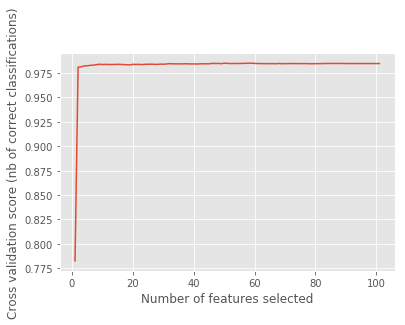

In [100]:
# Define a classifier
lr = LogisticRegression(penalty='l2',C=0.5)
# rf = RandomForestClassifier(n_estimators=100)
# lgbm = lgb.LGBMClassifier()
rfecv = RFECV(lr,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(sub_train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(sub_test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(sub_test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [101]:
rfecv.ranking_

array([31, 42,  1, 13,  1, 24,  1,  1,  1, 38, 27,  1,  1, 40,  1, 43,  1,
        1,  1, 36,  1,  1, 17, 26, 35,  1, 39,  1,  1, 14,  1, 29, 33,  1,
       28,  1, 16, 32, 30, 11,  1,  1, 37,  1, 19,  7,  1, 15,  1,  1,  1,
        1, 21,  1,  1,  1,  2,  1, 12,  1, 23,  1, 20,  1,  8,  1, 22,  3,
        1,  5,  1, 34,  1,  1,  1,  1, 25,  1,  1, 41,  1,  1,  1,  1,  1,
       10,  9,  1,  1,  1,  1,  1,  1,  1,  1,  6,  4,  1, 18,  1,  1])

In [ ]:
cross_val_score()